In [1]:
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))
def unit_vector(angle):
    return np.array([np.cos(angle), np.sin(angle)])
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
def render_ep (boat_plot, index=-1, tw_vec=0, target=False):
    from matplotlib import pyplot as plt
    #true wind vector
    
    #define plots
    fig, ax = plt.subplots()

    #define coordinates and directions
    if tw_vec.all!=0:
        x = 10
        y = 10
        u = tw_vec[0]
        v = tw_vec[1]

    #create quiver plot
    ax.quiver(x, y, u, v)
    #starting point
    #target point
    #PENDING: spline connecting each point
    
    boat_plot=np.split(boat_plot,len(boat_plot)/2)
    boat_plot=np.array(boat_plot)
    # Scatter plot
    #light blue -> darker blue 
    target_plot=env.target_position
    x=boat_plot[:, 0]
    y=boat_plot[:, 1]
    weights = np.arange(1,boat_plot[:, 1].shape[0]+1)
    plt.scatter(x, y, c=weights, cmap='Blues')
    if index!=-1:
        plt.title(f"{index}-th episode")
    if target==True:
        plt.scatter(target_plot[0], target_plot[1],c='red')
    # Display the plot
    plt.show()
    #plt.xlim(min(x),max(x))
    #plt.ylim(min(y),max(y))



In [2]:
import numpy as np

class SailBoatEnvironment:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.35):
        self.step_num=0
        #self.true_wind_direction = np.random.uniform(0, 2*np.pi)
        #PENDING: starting boat pos + target pos kalytera na orizontai sthn init para sthn reset
        #kai h reset na ta pairnei apo tin init
        self.boat_position = np.array([0, 0])
        self.target_position = np.array([55,100])
        #self.target_position = np.array([np.random.uniform(-10, 10), np.random.uniform(-10, 10)])
        self.sail_configs = np.linspace(0, 1, 16) #16 allowed positions of the sail
        self.rudder_configs = np.linspace(-np.pi/4, np.pi/4, 16) #The values of -np.pi/4 and np.pi/4 are chosen to represent the limits of the rudder configuration. These values correspond to the maximum angles 
                                                                #that the rudder can be turned left and right from the center position.The choice of np.pi/4 as the maximum #
                                                                # angle is somewhat arbitrary, but it is a common choice in sailing and boating applications.
        self.target_possible_angles=np.rad2deg(np.linspace(0, 2*np.pi, 16))
        self.tw_possible_angles=np.rad2deg(np.linspace(0, np.pi, 16))
        
        
        #self.q_table = np.zeros((16, 16, 3))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def reset(self):
        #returns
        #i)boat position: starting point of boat        
        #ii)random wind direction, epistrefei to index sto self.tw_possible_angles
        #iii)ypologizei thn target angle, thn diakritopoiei se mia apo tis dekaksi times kai epistrefei to index
        #toy self.target_possible_angles
        self.step_num=0
        #self.true_wind_direction = self.target_possible_angles[0]
        self.true_wind_direction = np.random.choice(np.rad2deg(np.linspace(0, np.pi, 16)))
        #self.true_wind_direction -> prepei na einai gwnia
        self.true_wind_direction = find_nearest(self.tw_possible_angles, value=self.true_wind_direction)
        self.boat_position = np.array([0, 0]) #fixed starting point
        self.target_position = np.array([55,100]) #fixed target position
        #self.max_distance=np.linalg.norm(self.boat_position-self.target_position)
        self.target_angle=angle_between(self.boat_position, self.target_position)
        self.target_angle=find_nearest(self.target_possible_angles, value=self.target_angle)
        return self.boat_position, np.where(self.true_wind_direction==self.tw_possible_angles)[0][0], \
        np.where(self.target_angle==self.target_possible_angles)[0][0]
        
        

    def get_state(self):
        relative_wind_direction = self.true_wind_direction - np.arctan2(*self.boat_position[::-1])
        #relative_wind_direction = find_nearest(self.target_possible_angles, value=relative_wind_direction)
        distance_to_target = np.linalg.norm(self.boat_position - self.target_position)
        return relative_wind_direction, distance_to_target

    def step(self, action):
        #returns
        #i)boat position: starting point of boat        
        #ii)random wind direction, epistrefei to index sto self.target_possible_angles
        #iii)ypologizei thn target angle, thn diakritopoiei se mia apo tis dekaksi times kai epistrefei to index
        #toy self.target_possible_angles
        #iv) step reward
        #v) done status
        #vi) truncated status
        #vii) number of steps
        sail_config, rudder_config = action
        sail_force = sail_config * np.sin(self.true_wind_direction - np.arctan2(*self.boat_position[::-1]))
        rudder_force = rudder_config * np.cos(self.true_wind_direction - np.arctan2(*self.boat_position[::-1]))
        boat_velocity = np.array([np.cos(self.true_wind_direction), np.sin(self.true_wind_direction)]) * sail_force + np.array([-np.sin(self.true_wind_direction), np.cos(self.true_wind_direction)]) * rudder_force
        self.boat_position = self.boat_position + boat_velocity#.astype(np.float64)
        self.target_angle=angle_between(self.boat_position, self.target_position)
        self.target_angle=find_nearest(self.target_possible_angles, value=self.target_angle)
        
        state = self.get_state()
        self.step_num+=1
        done = False
        truncated = False
        reward = -1

        #if np.any(np.abs(self.boat_position) > 20):
            #done = True
            #reward = -10

        distance_to_target = state[1]
        if distance_to_target < 1:
        #if distance_to_target//self.max_distance < 0.5: #kapws pio sxetiko giati den kseroume to distance 0.5
            #an einia megalo h mikro
            done = True
            reward = 100
        
        if self.step_num >= 2_500:
            truncated = True
            #done = True #gia na spaei h loupa tou training

#         # Q-learning update
#         sail_idx = np.argmin(np.abs(self.sail_configs - sail_config))
#         rudder_idx = np.argmin(np.abs(self.rudder_configs - rudder_config))
#         q_current = self.q_table[sail_idx, rudder_idx, 0]
#         q_next = np.max(self.q_table[sail_idx, rudder_idx, :])
#         self.q_table[sail_idx, rudder_idx, 0] += self.alpha * (reward + self.gamma * q_next - q_current)

        #return boat_velocity, self.boat_position, state, reward, done, self.step_num, self.target_angle
        return self.boat_position, np.where(self.true_wind_direction==self.tw_possible_angles)[0][0],\
        np.where(self.target_angle==self.target_possible_angles)[0][0], reward, \
        done, truncated, self.step_num


In [6]:
# env=SailBoatEnvironment()
# np.linalg.norm(env.boat_position-env.target_position)
#OUTPUT= 114.12712210513327 units

# Plot random movement

In [7]:
# env=SailBoatEnvironment()
# env.reset()
# done=False
# truncated=False
# boat_plot=[]
# while not truncated:
#     mlist=np.random.choice(np.linspace(0, 1, 16)), np.random.choice(np.linspace(-np.pi/4, np.pi/4, 16))
#     boat_pos, true_wind_index, target_angle_index,  reward, done, truncated, step_num = env.step(mlist)
#     #print(truncated)
#     boat_plot=np.append(boat_plot,np.array(boat_pos))
# #print(step_num)
# #boat_plot
# render_ep(boat_plot)

# Start env & Define Q Table

In [3]:
env=SailBoatEnvironment()
#current state = true wind direction + angle of boat to target wrt x axis
#prwto einai gia true wind angles
a=len(env.tw_possible_angles)
#deytera gia gwnies pros target
b=len(env.target_possible_angles)
#trito ola ta possible actions
c=32
q_table = np.random.uniform(low=-2, high=0, size=(a,b,c))
#q_table
#wd=0,1,2 # wd=1
#dt=0,1 #dt=0 makria, dt=1 konta
#np.argmax(q_table[1,1])
#
#rudder conf = 0:15th column
#np.argmax(q_table[state,0:15])
#sail conf = 16:31th columns
#np.argmax(q_table[state,16:32])



 # (testing) indices

In [4]:
a=np.arange(1,110,10)
a

array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101])

In [5]:
b=a[5:12]
b

array([ 51,  61,  71,  81,  91, 101])

In [6]:
np.argmax(b) 

5

In [7]:
b[5]

101

In [8]:
a[5+5]

101

In [9]:
env.reset()  

(array([0, 0]), 8, 12)

# Train Q table

In [10]:
env=SailBoatEnvironment()
EPISODES=20_000
tw_direction=[]
boat_plot=[]
boat_plot_all_ep=[] #stores all episodes' movement
dones=np.zeros(EPISODES)
for i in range(EPISODES):
    boat_plot=[]
    current_state=env.reset()    
    current_state=current_state[1], current_state[2]
    tw_direction=np.append(tw_direction,current_state[0])
    done=False
    truncated=False
    while not done: # or not truncated:
    #rudder_conf=env.rudder_configs[rudder_conf_index]
    #rudder_conf
        sail_conf_index=np.argmax(q_table[(current_state)][0:16])
        rudder_conf_index=np.argmax(q_table[(current_state)][16:33])
        #print(f"{i} ep: sail index->{sail_conf_index}, rudder index->{rudder_conf_index}")
        #H np.argmax epistrefei index, oxi timh, opote pairnoume to index pou mas epistrefei
        #kai blepoume apo ta *_configs poia timh antistoixei se ayto to index
        action=env.sail_configs[sail_conf_index],env.rudder_configs[rudder_conf_index]
        boat_pos,  true_wind_index, target_angle_index, reward, done, truncated, step_num = env.step(action)
        if done==True:
            print(f"{i}-th ep -> Egina done sto {step_num}-th step.")
            dones[i]=1
            break
        if truncated==True:
            #print(f"{i}-th ep -> Egina truncated")
            break
        new_state=true_wind_index, target_angle_index
        boat_plot=np.append(boat_plot,np.array(boat_pos))
        
        #Psaxnoume ta Q_max, ena gia to sail setting kai ena gia to rudder setting
        #Sto Q table exoume orisei aythaireta oti oi prwtes 16 columns [0:16] dhladh
        #antistoixoun sto sail setting
        #enw oi ypoloipes 16 columns [16:33] sto rudder config
        Q_max_sail=np.max(q_table[(current_state)][0:16])
        Q_max_rudder=np.max(q_table[(current_state)][16:33])
        q_current_sail=q_table[current_state+(sail_conf_index,)]
        q_current_rudder=q_table[current_state+(rudder_conf_index,)]
        new_q_sail=(1-env.alpha)*q_current_sail+env.alpha*(reward+env.gamma*Q_max_sail)
        new_q_rudder=(1-env.alpha)*q_current_rudder+env.alpha*(reward+env.gamma*Q_max_rudder)
        q_table[current_state+(sail_conf_index,)]=new_q_sail
        #15 h 16?
        q_table[current_state+(16+rudder_conf_index,)]=new_q_rudder
        current_state=new_state

    #print(i)
    boat_plot_all_ep.append(boat_plot)
    if i%800==0:
        print(f"{i}-th ep -> steps: {step_num}")
    
#plot last episode
#render_ep(boat_plot, EPISODES)

0-th ep -> steps: 2500
14-th ep -> Egina done sto 471-th step.
756-th ep -> Egina done sto 599-th step.
763-th ep -> Egina done sto 598-th step.
773-th ep -> Egina done sto 593-th step.
780-th ep -> Egina done sto 598-th step.
784-th ep -> Egina done sto 597-th step.
789-th ep -> Egina done sto 596-th step.
793-th ep -> Egina done sto 596-th step.
800-th ep -> steps: 2500
821-th ep -> Egina done sto 598-th step.
848-th ep -> Egina done sto 596-th step.
851-th ep -> Egina done sto 597-th step.
873-th ep -> Egina done sto 601-th step.
889-th ep -> Egina done sto 600-th step.
898-th ep -> Egina done sto 597-th step.
917-th ep -> Egina done sto 590-th step.
943-th ep -> Egina done sto 597-th step.
960-th ep -> Egina done sto 593-th step.
981-th ep -> Egina done sto 594-th step.
995-th ep -> Egina done sto 595-th step.
1004-th ep -> Egina done sto 436-th step.
1006-th ep -> Egina done sto 597-th step.
1007-th ep -> Egina done sto 391-th step.
1012-th ep -> Egina done sto 390-th step.
1053-t

In [13]:
# boat_array=np.split(boat_plot,len(boat_plot)/2)
# boat_array=np.array(boat_array)
# boat_array

In [11]:
dones
#Count number of successful episodes
num_successful_episodes=np.count_nonzero(dones == 1)
#Index of successful episodes
successful_indices=np.where(dones==1)[0]
print(f"posa epeisodia teleiwsa: {num_successful_episodes} apo ta {i} \ndhladh to {round(num_successful_episodes/i,2)*100}%")

posa epeisodia teleiwsa: 2251 apo ta 19999 
dhladh to 11.0%


In [12]:
np.unique(tw_direction)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15.])

In [13]:
# successful_indices
# tw_direction

In [14]:
#Vlepoume oti oloklhrwnei epeisodia mono otan to wind direction einai sygkekrimeno (?)

tw_direction[successful_indices]


array([14.,  3.,  3., ...,  1.,  1.,  1.])

In [15]:
np.unique(tw_direction[successful_indices])

array([ 1.,  2.,  3.,  7.,  8.,  9., 13., 14.])

In [16]:
np.unique(tw_direction[successful_indices], return_index=True)[1] #indices

array([1057,  241,    1,  291,   19,  318,   65,    0])

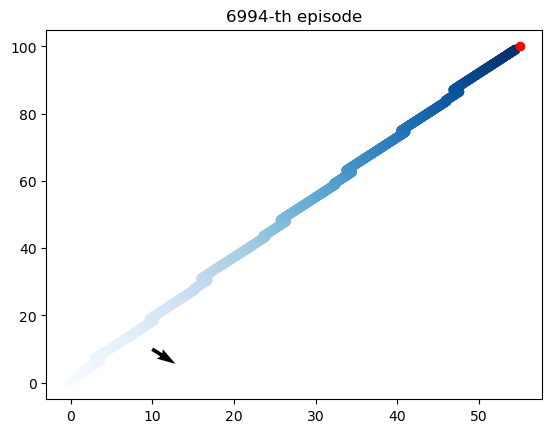

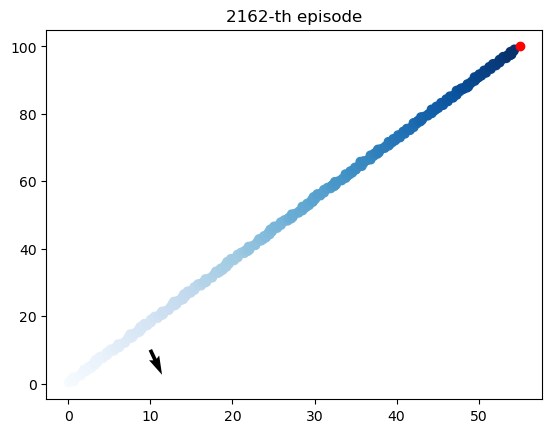

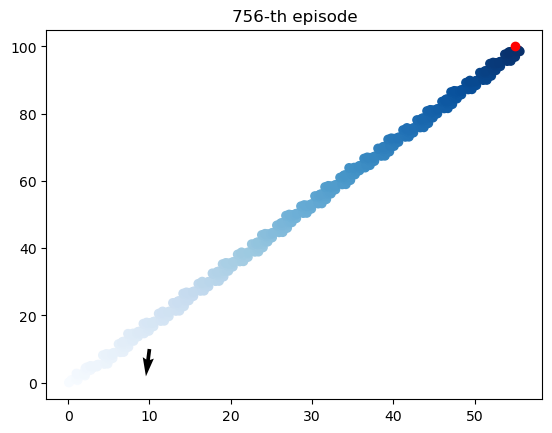

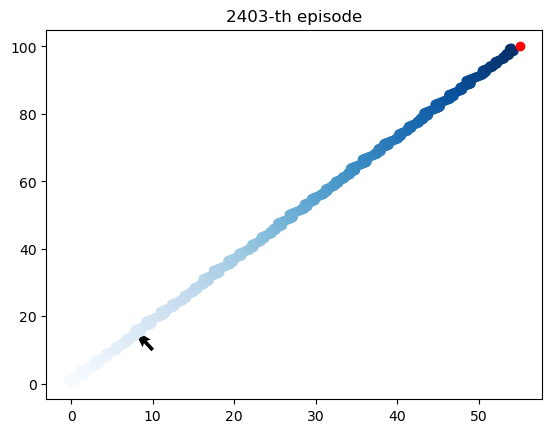

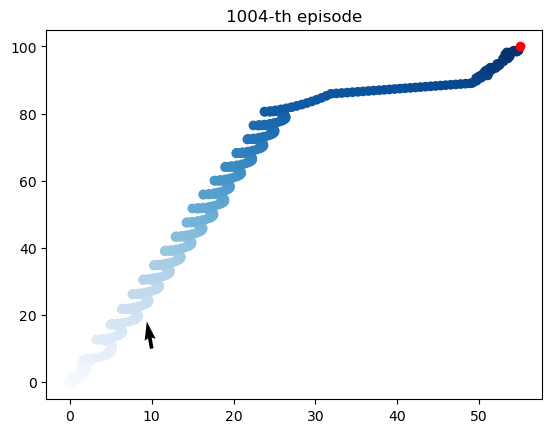

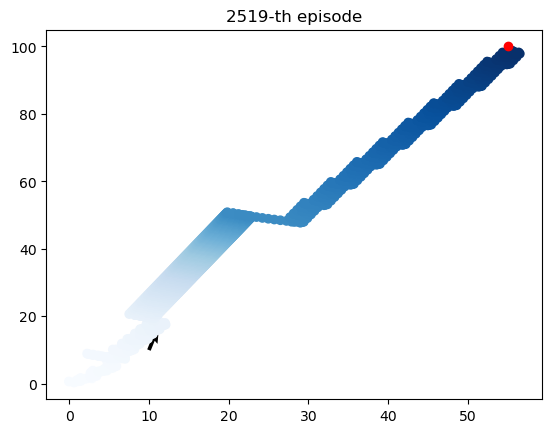

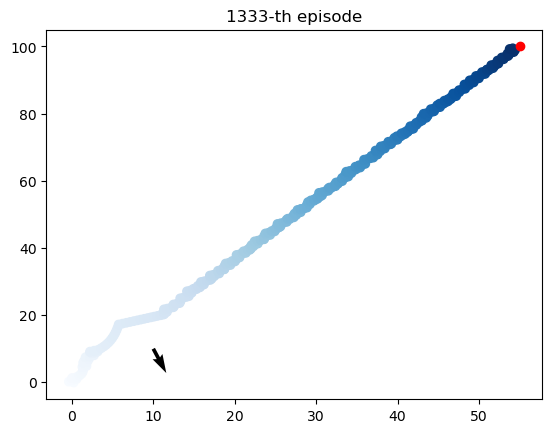

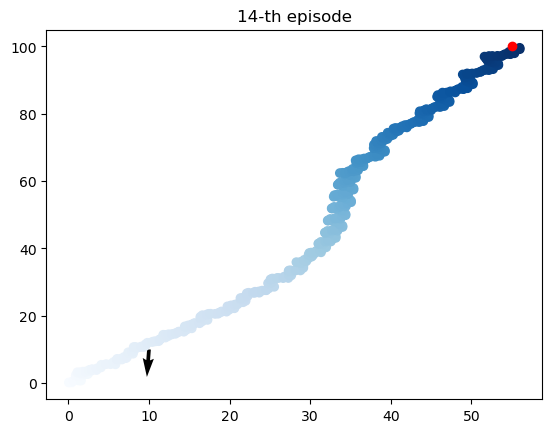

In [17]:
for i in np.unique(tw_direction[successful_indices], return_index=True)[1]:
    vec=unit_vector(env.tw_possible_angles[int(tw_direction[successful_indices[i]])])
    render_ep(boat_plot_all_ep[successful_indices[i]],successful_indices[i], vec, True)

In [18]:
for i in np.unique(tw_direction[successful_indices]):
    
    print(f"true wind direction gia thn opoia ginetai done: {env.tw_possible_angles[int(i)]}")

true wind direction gia thn opoia ginetai done: 12.0
true wind direction gia thn opoia ginetai done: 24.0
true wind direction gia thn opoia ginetai done: 36.0
true wind direction gia thn opoia ginetai done: 83.99999999999999
true wind direction gia thn opoia ginetai done: 96.0
true wind direction gia thn opoia ginetai done: 108.0
true wind direction gia thn opoia ginetai done: 156.0
true wind direction gia thn opoia ginetai done: 167.99999999999997


# Plot some episodes that reached target

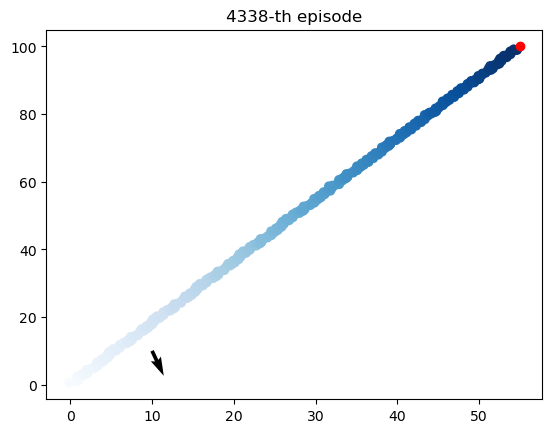

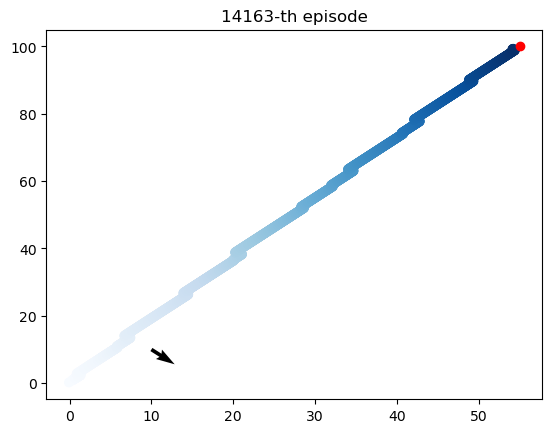

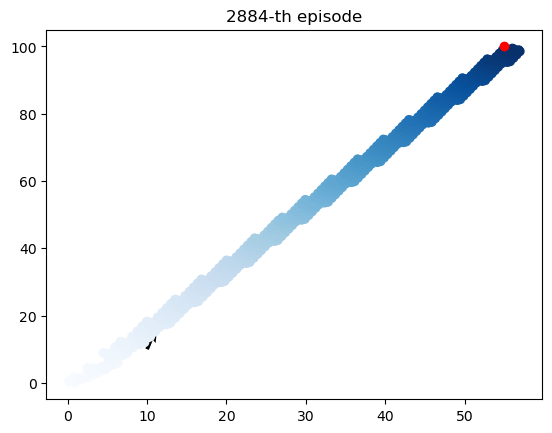

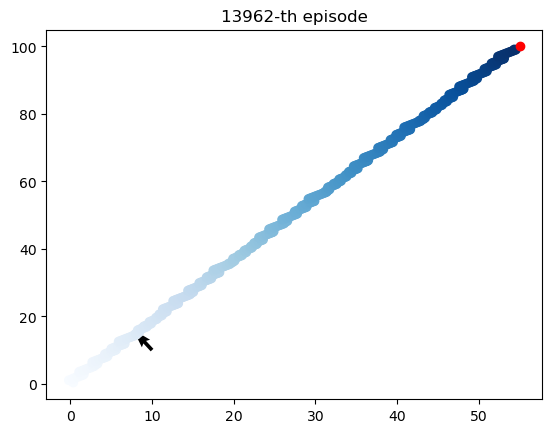

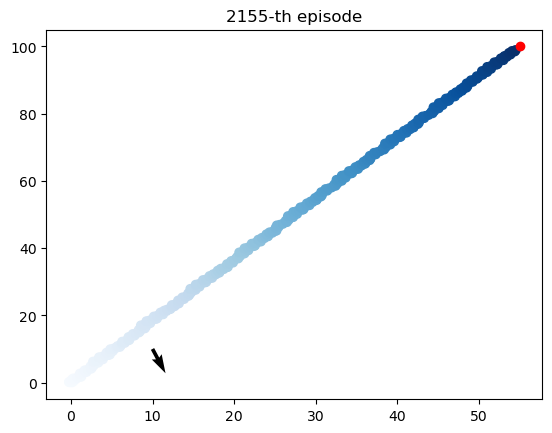

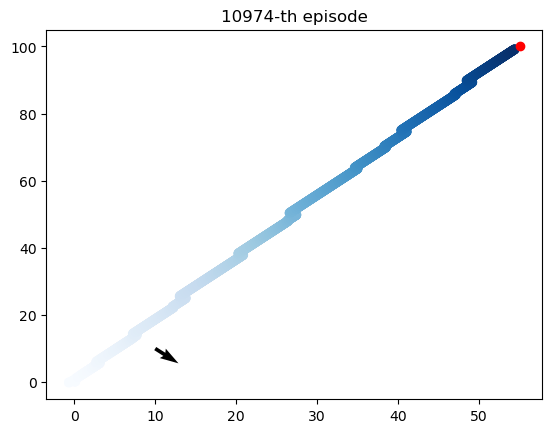

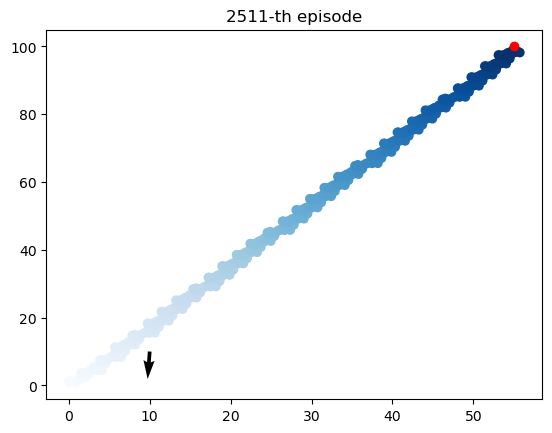

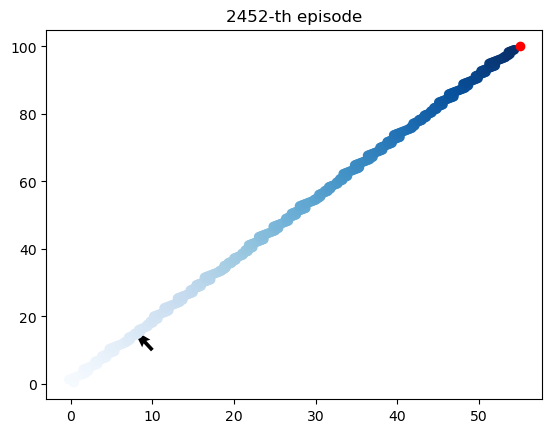

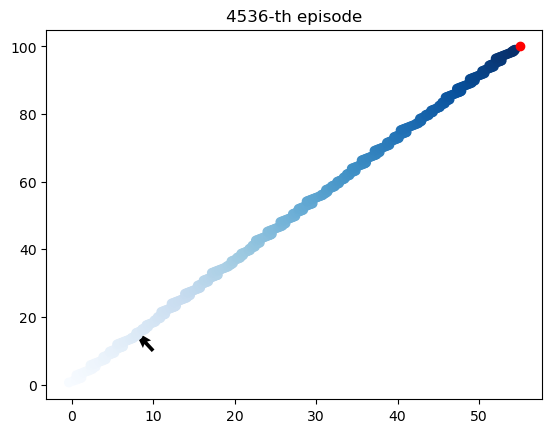

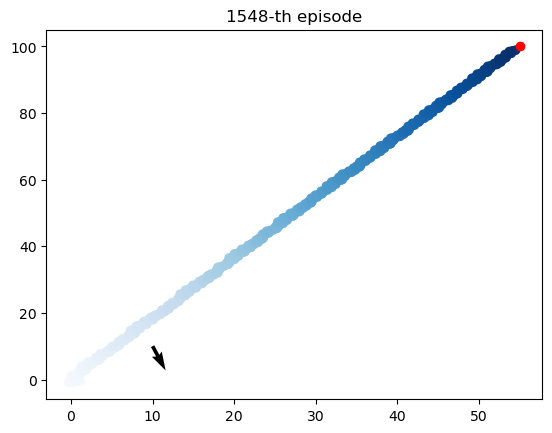

In [19]:
if len(successful_indices)!=0:
    for i in np.random.choice(successful_indices, size=10, replace=False):
        vec=unit_vector(env.tw_possible_angles[int(tw_direction[i])])
        render_ep(boat_plot_all_ep[i], i, vec, True)
else:
    print("|Kanena epeisodio den oloklirwthike.|")

# sovaro

(array([   14,    23,    41, ..., 19982, 19998, 19999]),)


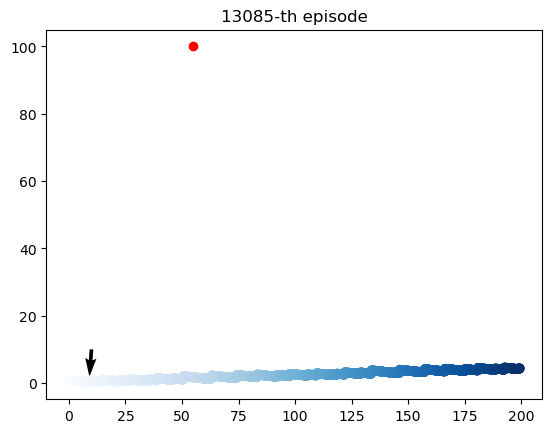

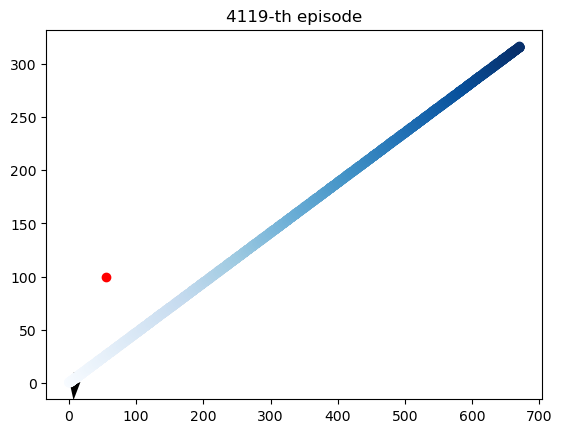

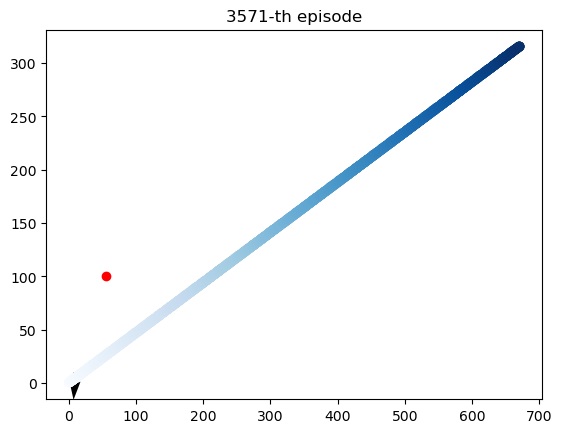

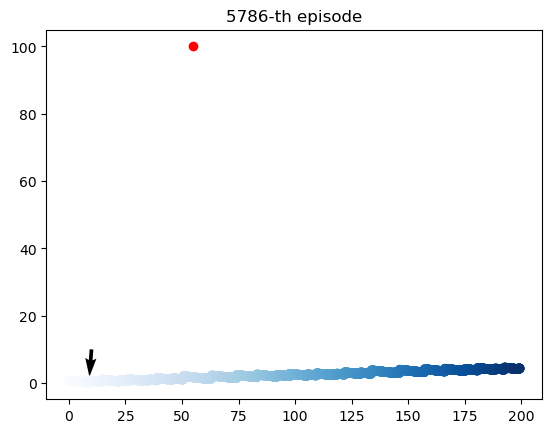

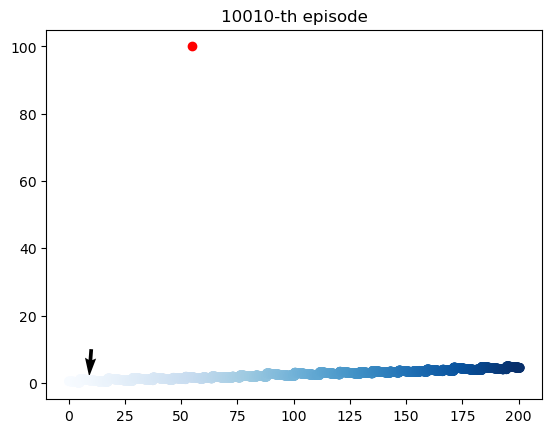

(array([   16,    31,    33, ..., 19941, 19963, 19969]),)


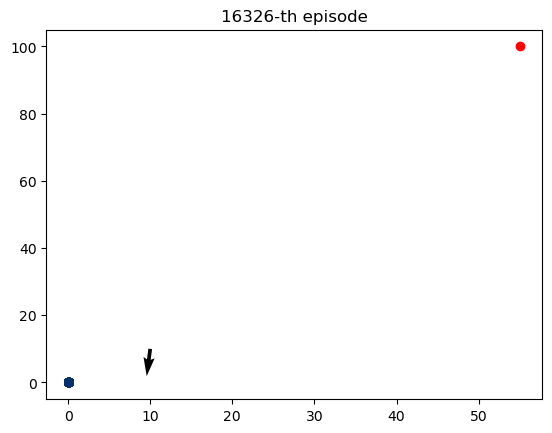

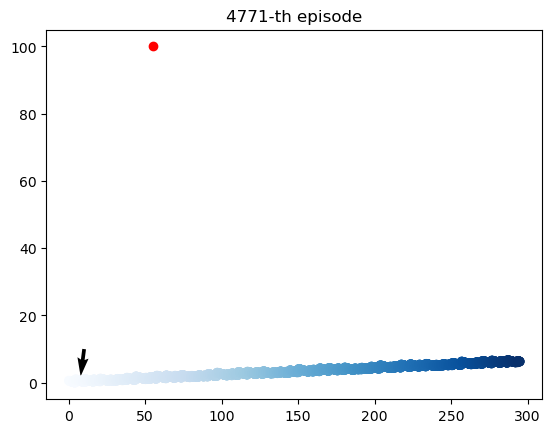

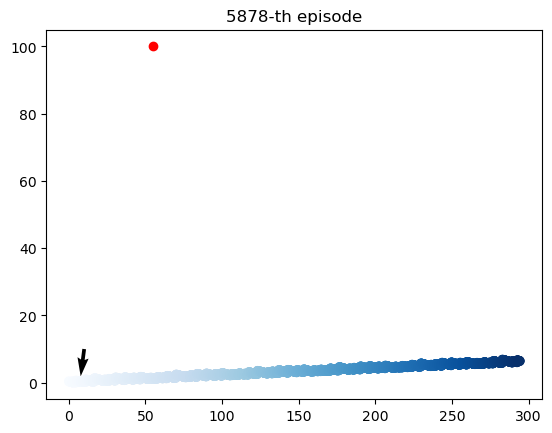

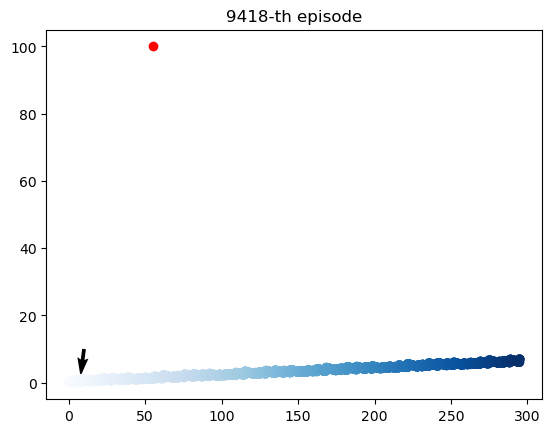

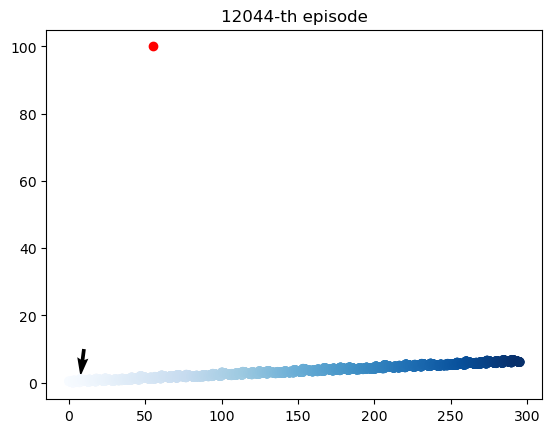

(array([   16,    31,    33, ..., 19941, 19963, 19969]),)


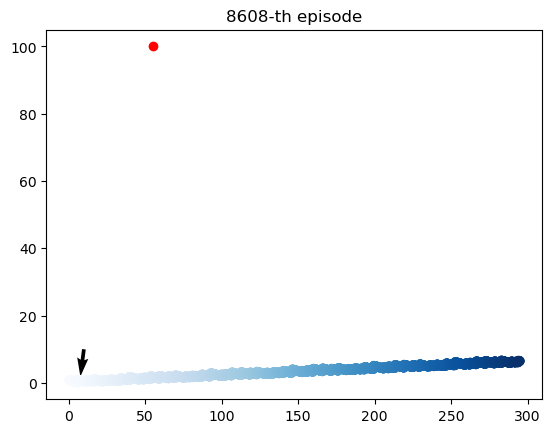

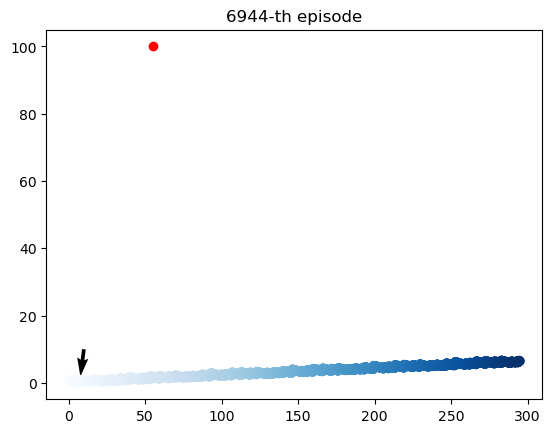

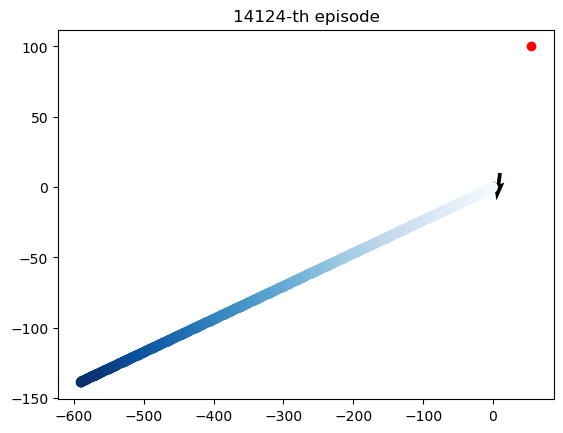

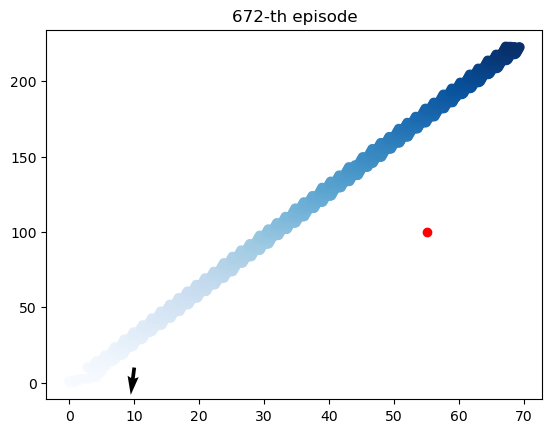

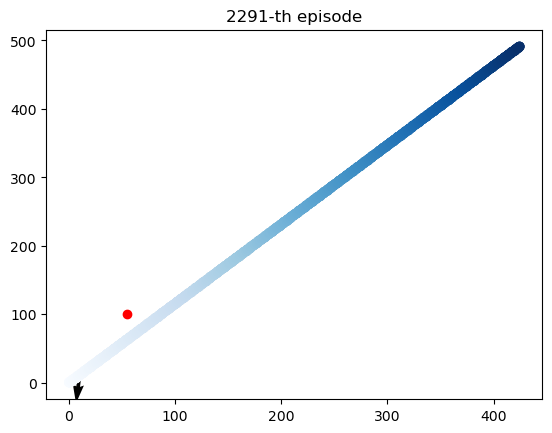

(array([   16,    31,    33, ..., 19941, 19963, 19969]),)


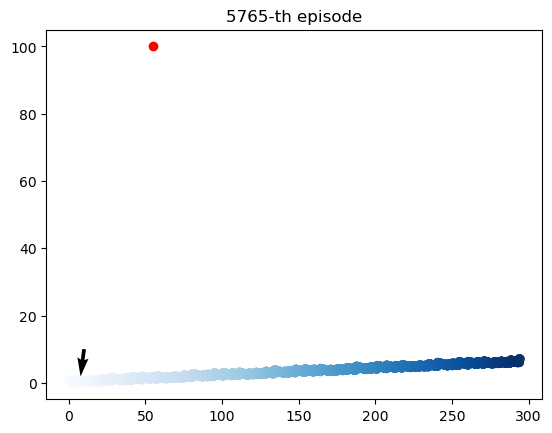

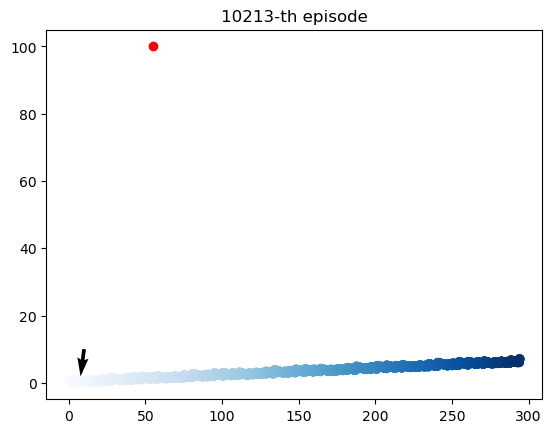

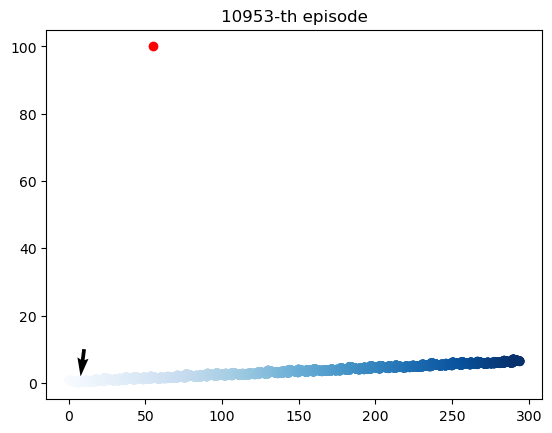

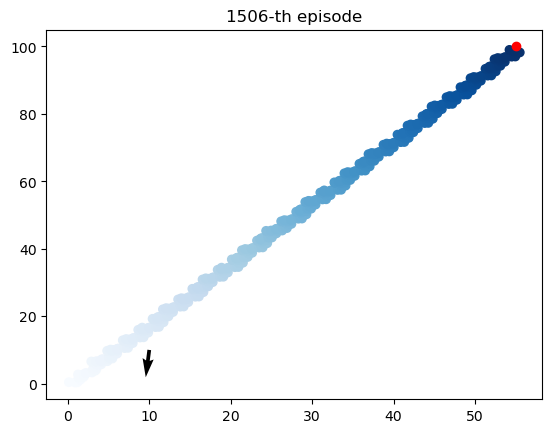

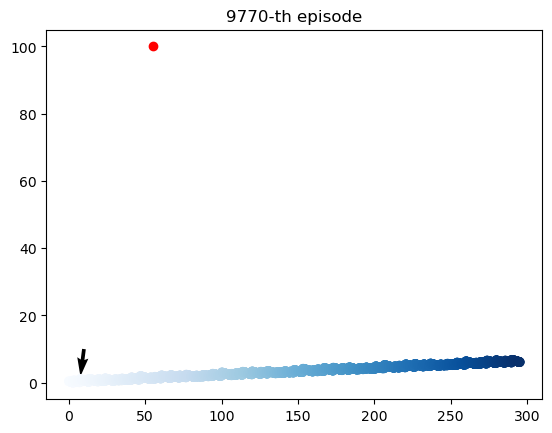

(array([   16,    31,    33, ..., 19941, 19963, 19969]),)


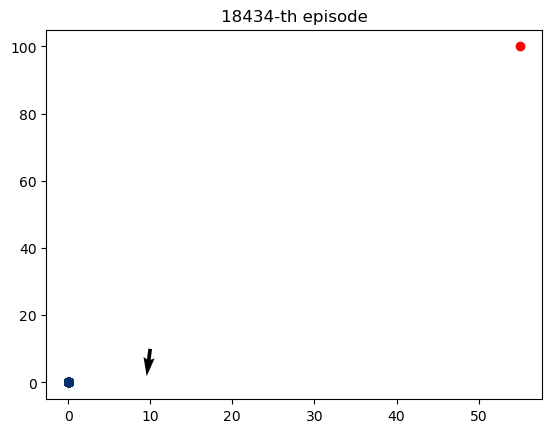

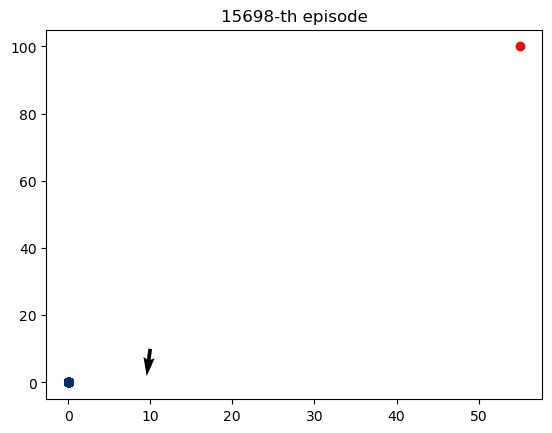

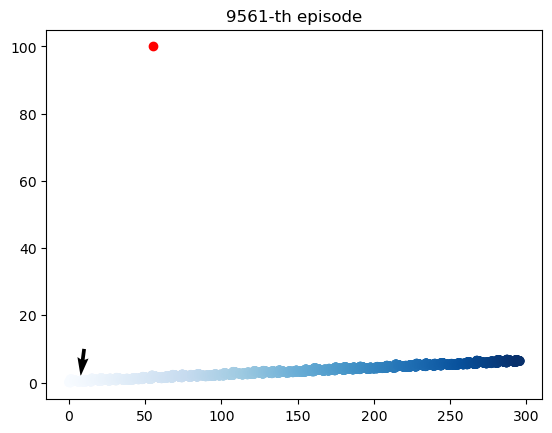

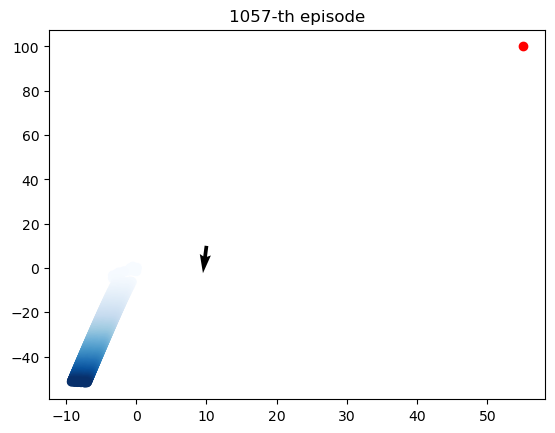

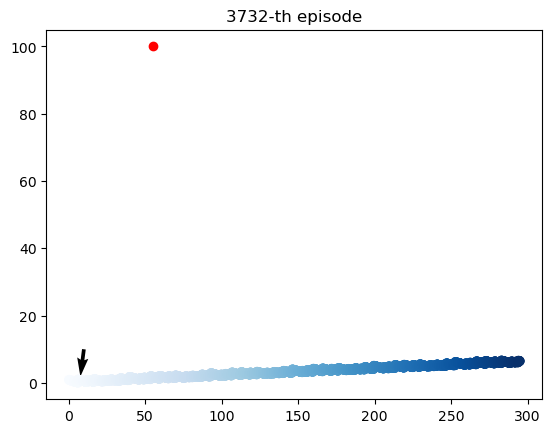

(array([   16,    31,    33, ..., 19941, 19963, 19969]),)


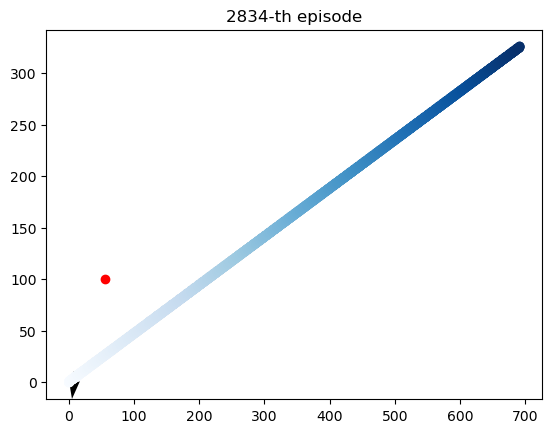

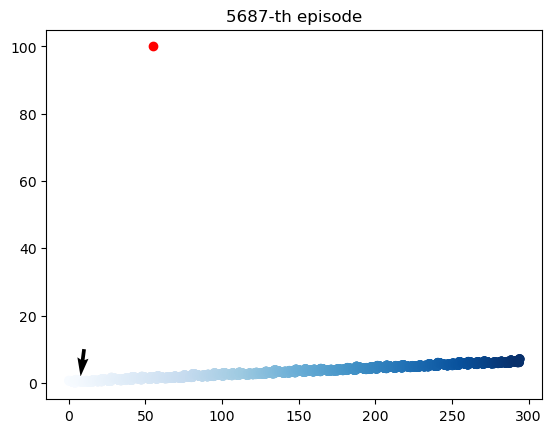

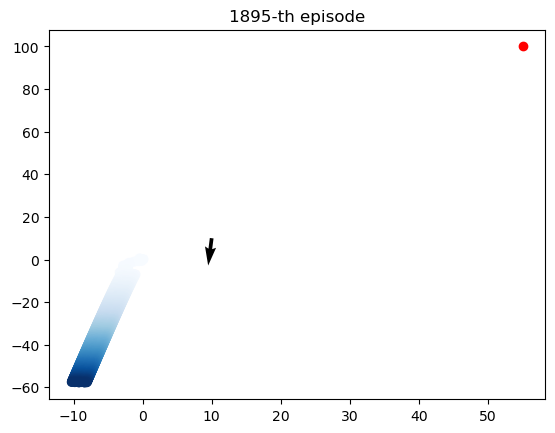

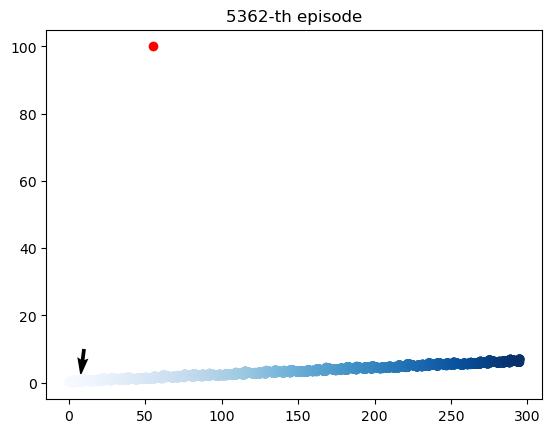

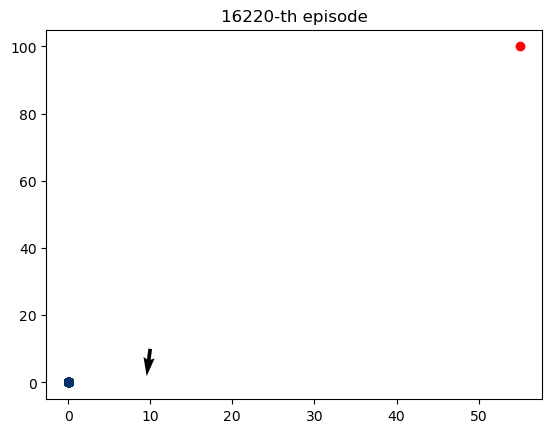

(array([   16,    31,    33, ..., 19941, 19963, 19969]),)


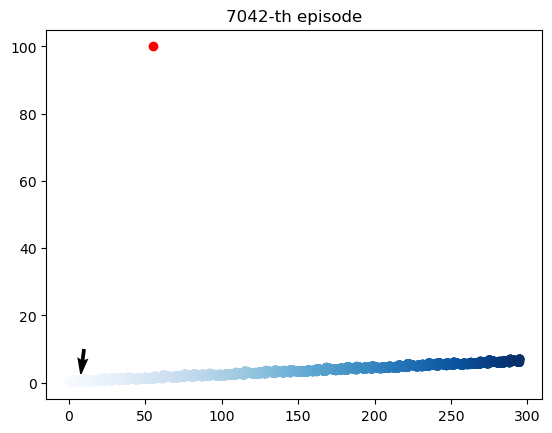

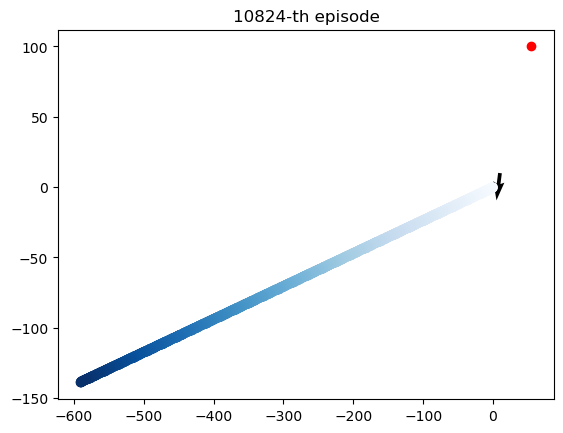

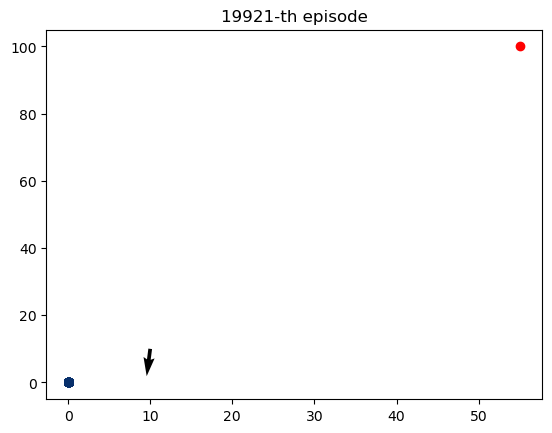

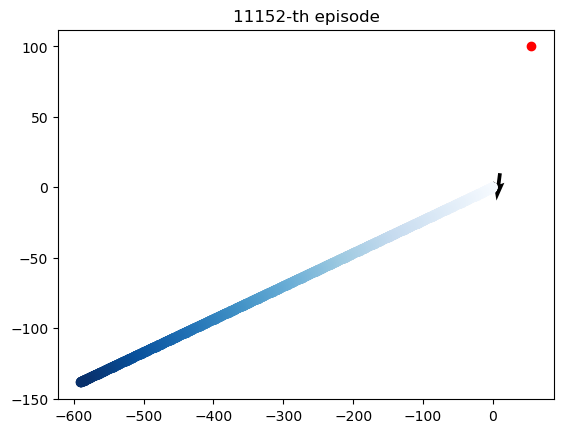

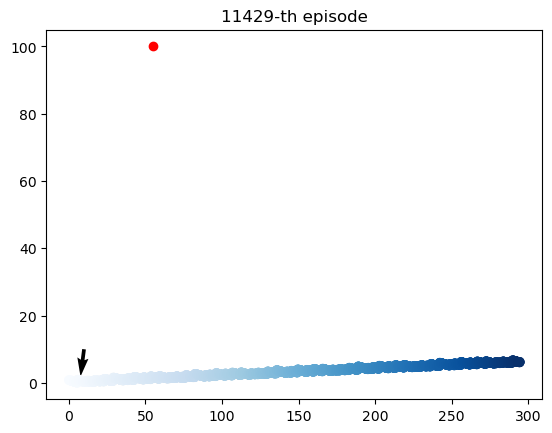

(array([   16,    31,    33, ..., 19941, 19963, 19969]),)


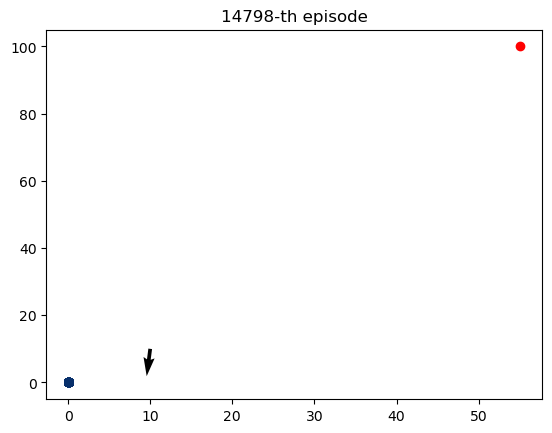

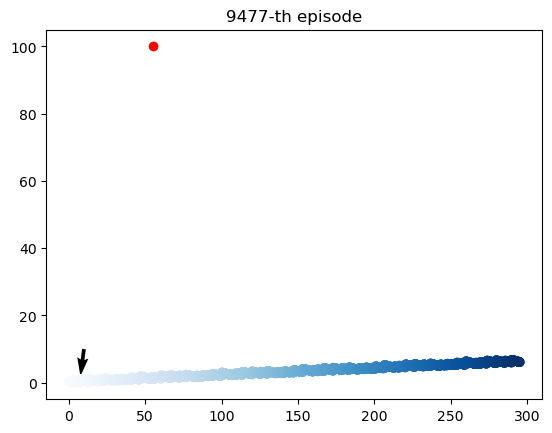

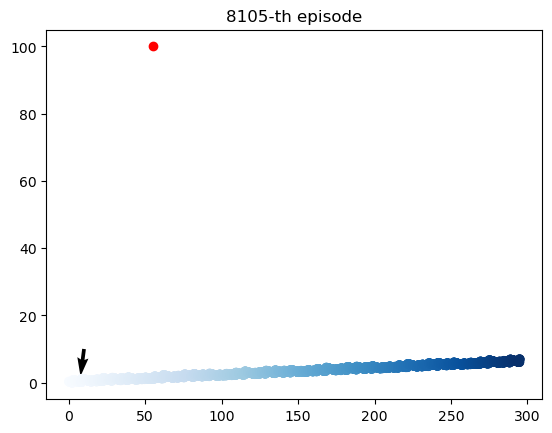

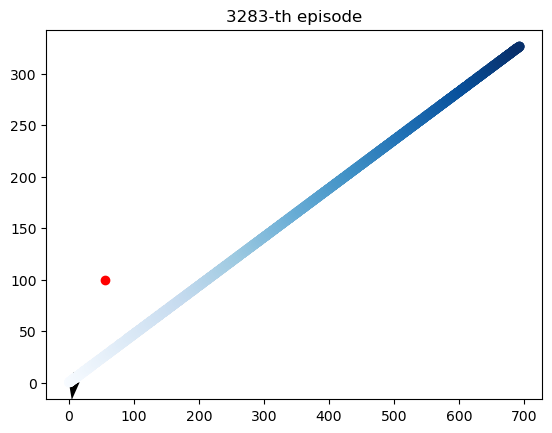

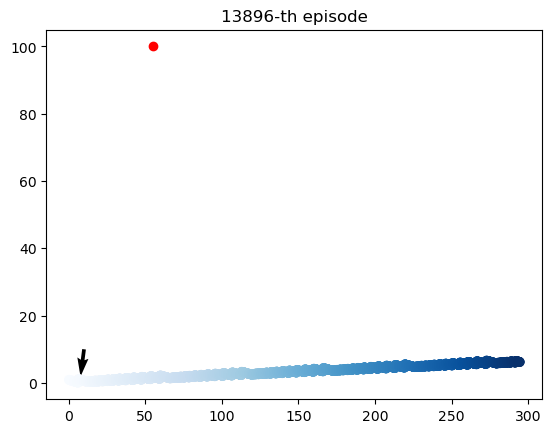

In [20]:
for jj in range(len(np.unique(tw_direction[successful_indices]))):
     print(np.where(tw_direction==np.unique(tw_direction[successful_indices][jj])))
     from_here=np.where(tw_direction==np.unique(tw_direction[successful_indices][jj]))[0]
     for i in np.random.choice(from_here, size=5, replace=False):
         vec=unit_vector(env.tw_possible_angles[int(tw_direction[i])])
         render_ep(boat_plot_all_ep[i], i, vec, True)

# Plot every 1000 episodes

AttributeError: 'int' object has no attribute 'all'

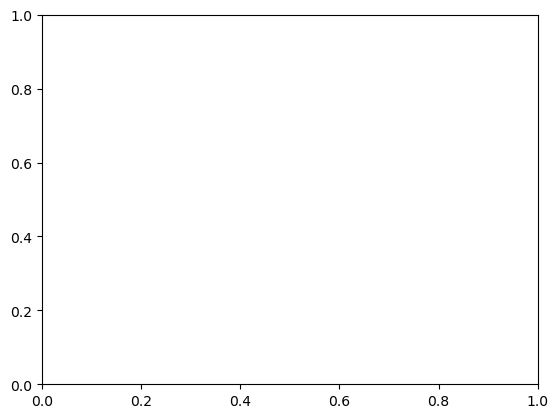

In [22]:
for i in np.arange(0,EPISODES, 1000):
    render_ep(boat_plot_all_ep[i], i)

# Test Q Table

In [ ]:
# env=SailBoatEnvironment()
# for i in range(100):
#     current_state=env.reset()
#     current_state=current_state[1], current_state[2]
#     done=False
#     while not done:
#     #rudder_conf=env.rudder_configs[rudder_conf_index]
#     #rudder_conf
#         sail_conf_index=np.argmax(q_table[(current_state)][0:15])
#         rudder_conf_index=np.argmax(q_table[(current_state)][15:33])
#         #sail_conf=env.sail_configs[sail_conf_index]
#         #sail_conf
#         action=env.sail_configs[sail_conf_index],env.rudder_configs[15-rudder_conf_index]
#         boat_pos,  true_wind_index, target_angle_index, reward, done, truncated, step_num = env.step(action)
#         new_state=true_wind_index, target_angle_index
#         #plotting a single episode
#         #boat_plot=np.append(boat_plot,np.array(boat_pos))
# #         Q_max_sail=np.max(q_table[(current_state)][0:15])
# #         Q_max_rudder=np.max(q_table[(current_state)][15:33])
# #         q_current_sail=q_table[current_state+(sail_conf_index,)]
# #         q_current_rudder=q_table[current_state+(15+sail_conf_index,)]
# #         new_q_sail=(1-env.alpha)*q_current_sail+env.alpha*(reward+env.gamma*Q_max_sail)
# #         new_q_rudder=(1-env.alpha)*q_current_rudder+env.alpha*(reward+env.gamma*Q_max_rudder)
# #         q_table[current_state+(sail_conf_index,)]=new_q_sail
# #         q_table[current_state+(15+sail_conf_index,)]=new_q_rudder
#         current_state=new_state
#     if i%5==0:
#         print(f"{i}-th ep -> steps: {step_num}")

In [ ]:
# env=SailBoatEnvironment()
# q_table = np.zeros((16, 16, 3))

# num_episodes = 1
# #num_steps = 1000
# for episode in range(num_episodes):
#     state = env.reset()
#     done = False
#     total_reward = 0
#     while not done:
#         # Choose action using epsilon-greedy policy
        
#         #if np.random.uniform() < env.epsilon:
#             #action = [np.random.choice(env.sail_configs), np.random.choice(env.rudder_configs)]
#         #else:
#         sail_idx, rudder_idx = np.searchsorted(env.sail_configs, action[0]), np.searchsorted(env.rudder_configs, action[1])
#         action = [env.sail_configs[sail_idx], env.rudder_configs[rudder_idx]]
        
#         # Take action
#         boat_v, boat_pos, next_state, reward, done, step_number = env.step(action)
        
#         # Update Q-table
#         sail_idx, rudder_idx = np.searchsorted(env.sail_configs, action[0]), np.searchsorted(env.rudder_configs, action[1])
#         q_current = q_table[sail_idx, rudder_idx, 0]
#         q_next = np.max(q_table[sail_idx, rudder_idx, :])
#         q_table[sail_idx, rudder_idx, 0] += env.alpha * (reward + env.gamma * q_next - q_current)
        
#         state = next_state
#         total_reward += reward
#         #print(f"Step: {step_number}, BoatV:{np.round(boat_v,2)} , Boat Pos:{np.round(boat_pos,2)}")
#     #print(f"Episode {episode+1}, BoatV:{boat_v} , Boat Pos:{boat_pos}")


In [ ]:
# import matplotlib.pyplot as plt

# env = SailBoatEnvironment()
# num_episodes = 3000
# num_steps =1000

# # create empty arrays to store positions for each episode
# boat_positions = np.zeros((num_episodes, 2)) 
# target_positions = np.tile(np.array([55,100]), (num_episodes, 1))

# for episode in range(num_episodes):
#     state = env.reset()
#     done = False
#     total_reward = 0
#     while not done:
#         # Choose action using epsilon-greedy policy
#         if np.random.uniform() < env.epsilon:
#             action = [np.random.choice(env.sail_configs), np.random.choice(env.rudder_configs)]
#         else:
#             sail_idx, rudder_idx = np.searchsorted(env.sail_configs, action[0]), np.searchsorted(env.rudder_configs, action[1])
#             action = [env.sail_configs[sail_idx], env.rudder_configs[rudder_idx]]

#         # Take action
#         boat_v, boat_pos, next_state, reward, done = env.step(action)
        

#         # Update Q-table
#         sail_idx, rudder_idx = np.searchsorted(env.sail_configs, action[0]), np.searchsorted(env.rudder_configs, action[1])
#         q_current = q_table[sail_idx, rudder_idx, 0]
#         q_next = np.max(q_table[sail_idx, rudder_idx, :])
#         q_table[sail_idx, rudder_idx, 0] += env.alpha * (reward + env.gamma * q_next - q_current)

#         state = next_state
#         total_reward += reward
    
#     # store final position in boat_positions array
#     boat_positions[episode, :] = state
    
#     print(f"Episode {episode+1}, Total reward: {total_reward}, New Position: ({state[0]:.2f}, {state[1]:.2f}), Target Position: ({env.target_position[0]:.2f}, {env.target_position[1]:.2f})")

# # create scatter plot of boat positions and target positions
# fig, ax = plt.subplots()
# ax.scatter(target_positions[:, 0], target_positions[:, 1], color='red',label='Target Position')
# ax.scatter(boat_positions[:, 0], boat_positions[:, 1], color='gray', label='Boat Position')
# ax.legend()
# plt.show()


the Q-table is a 3-dimensional numpy array with dimensions (11, 11, 3). The first two dimensions correspond to the sail and rudder configurations, respectively, and the third dimension corresponds to the Q-values for each possible action (there are 3 actions in total: sail left, sail straight, and sail right).

self.true_wind_direction is a random value between 0 and 2π.
self.boat_position is a NumPy array containing the initial position of the boat, which is (0, 0).
self.target_position is a NumPy array containing the position of the target, which is a random point within a rectangle centered at the origin with width and height of 20 units.
self.sail_configs is a NumPy array containing 11 equally spaced values between 0 and 1, representing the possible sail configurations.
self.rudder_configs is a NumPy array containing 11 equally spaced values between -π/4 and π/4, representing the possible rudder configurations.
self.q_table is a 3-dimensional NumPy array of zeros with shape (11, 11, 3), representing the Q-values for each possible combination of sail and rudder configurations.

sail_idx = np.argmin(np.abs(self.sail_configs - sail_config)) finds the index of the sail configuration that is closest to the desired sail configuration specified by sail_config. This is used to index into the first dimension of the Q-table.

rudder_idx = np.argmin(np.abs(self.rudder_configs - rudder_config)) finds the index of the rudder configuration that is closest to the desired rudder configuration specified by rudder_config. This is used to index into the second dimension of the Q-table.

q_current = self.q_table[sail_idx, rudder_idx, 0] retrieves the current Q-value for the current state and action (which is the "sail straight" action, corresponding to the index 0 in the third dimension).

q_next = np.max(self.q_table[sail_idx, rudder_idx, :]) computes the estimated Q-value for the next state, which is the maximum Q-value over all possible actions in the next state (i.e., the action that maximizes the Q-value). This is used to estimate the expected total reward that can be obtained from the next state.

self.q_table[sail_idx, rudder_idx, 0] += self.alpha * (reward + self.gamma * q_next - q_current) updates the Q-value for the current state and action, using the Q-learning update rule

The Q-learning update equation is used to update the Q-value for the current state and action. The Q-value for the current state and action is q_current, and q_next is the maximum Q-value for the next state. The update is performed as follows:

new_q_value = old_q_value + learning_rate * (reward + discount_factor * max_q_next - old_q_value)

where learning_rate is the step size, reward is the reward obtained from the current action, discount_factor is the discount factor for future rewards, and max_q_next is the maximum Q-value for the next state.

In the code, q_current is the current Q-value for the current state and action, and q_next is the maximum Q-value for the next state. The Q-value for the current state and action is updated using the above equation, and the new value is stored back in the Q-table.

relative_wind_direction = self.true_wind_direction - np.arctan2(*self.boat_position[::-1])
self.true_wind_direction: This is a scalar value that represents the direction of the wind, expressed in radians.
np.arctan2(*self.boat_position[::-1]): This is a function call to np.arctan2, which computes the arctangent of the ratio of two given inputs. In this case, the inputs are the components of the boat's position vector, reversed using [::-1]. The * before self.boat_position[::-1] unpacks the tuple of components into separate arguments for the np.arctan2 function. The resulting output is the angle in radians between the positive x-axis and a line connecting the boat's position to the origin.
self.true_wind_direction - np.arctan2(*self.boat_position[::-1]): This subtracts the angle from step 2 from the wind direction angle from step 1, resulting in the relative wind direction, which is the angle in radians between the boat's heading and the direction of the wind.
Overall, this line of code is computing the relative wind direction, which is an important parameter for calculating the sail force applied to the boat in the subsequent lines of code.